In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import gaussian_kde, linregress
from scipy.optimize import curve_fit

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
df_prod = pd.read_csv("arcade.csv")
print(df_prod.info())


# Create dictionary mapping from category_id to (main_category, sub_category)
category_map = (
    df_prod
    .drop_duplicates(subset="category_id")[["category_id", "main_category", "sub_category"]]
    .set_index("category_id")
    .apply(tuple, axis=1)
    .to_dict()
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7822 entries, 0 to 7821
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       7822 non-null   int64  
 1   year             7822 non-null   float64
 2   title            7822 non-null   object 
 3   firm             7822 non-null   object 
 4   firm_id          7822 non-null   int64  
 5   log_rom_size     7822 non-null   float64
 6   log_clock_speed  7822 non-null   float64
 7   collaboration    7822 non-null   object 
 8   main_category    7822 non-null   object 
 9   sub_category     7822 non-null   object 
 10  category_id      7822 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 672.3+ KB
None


In [2]:

# -----------------------------------
# FUNCTIONS
# -----------------------------------

def get_trait_evo(df, trait_col="log_rom_size"):
    """Extracts trait evolution data as a list of (index, value) pairs."""
    return [(index, getattr(row, trait_col)) for index, row in df.iterrows()]

def get_trait_diversity(df, trait_col="log_rom_size"):
    """Computes the cumulative number of unique trait values over time."""
    print(f"Subcategories in dataset: {set(df['sub_category'])}")
    
    trait_evolution = sorted(get_trait_evo(df, trait_col))
    times, values = zip(*trait_evolution)
    
    times = np.array(times)
    values = np.array(values)
    
    # Sort by time index while preserving gaps
    sorted_indices = np.argsort(times)
    original_times = times[sorted_indices]
    values_sorted = values[sorted_indices]
    
    # Compute cumulative number of unique traits
    unique_counts = []
    seen_traits = set()
    
    for value in values_sorted:
        seen_traits.add(value)
        unique_counts.append(len(seen_traits))
    
    return np.array(original_times), np.array(unique_counts)


def load_niche_category(df, main_cat, sub_cat_ids=None):
    """Loads data for a specific main category or subcategories."""
    if sub_cat_ids:
        return df[df['category_id'].isin(sub_cat_ids)]
    return df[df['main_category'] == main_cat]

In [3]:
# -----------------------------------
# DIVERSITY MODELS
# -----------------------------------

def heap_law(N, a, b):
    """Power-law function V(N) = a * N^b."""
    return a * N**b


In [4]:


# Store results here
results = []

# Define all unique category_ids and their (main, sub) names
category_ids = df_prod['category_id'].unique()

for category_id in category_ids:
    sub_df = df_prod[df_prod['category_id'] == category_id]
    N = len(sub_df)
    
    if N < 5:  # Skip very small categories
        continue

    main_cat, sub_cat = category_map[category_id]
    
    # --- Estimate exponent a: log(CPU) ~ log(ROM)
    x = sub_df['log_rom_size']
    y = sub_df['log_clock_speed']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    a = slope
    a_se = std_err

    # --- Estimate exponent b: Heap's law on ROM diversity
    try:
        idx, V = get_trait_diversity(sub_df, trait_col='log_rom_size')
        params_rom, cov_rom = curve_fit(heap_law, idx, V, maxfev=10000)
        b_rom, b_rom_se = params_rom[1], np.sqrt(np.diag(cov_rom))[1]
    except Exception as e:
        b_rom, b_rom_se = np.nan, np.nan

    # --- Heap's law on CPU diversity
    try:
        idx, V = get_trait_diversity(sub_df, trait_col='log_clock_speed')
        params_cpu, cov_cpu = curve_fit(heap_law, idx, V, maxfev=10000)
        b_cpu, b_cpu_se = params_cpu[1], np.sqrt(np.diag(cov_cpu))[1]
    except Exception as e:
        b_cpu, b_cpu_se = np.nan, np.nan

    # --- Bootleg/Collaboration Ratios
    collab_counts = sub_df['collaboration'].value_counts()
    num_bootleg = collab_counts.get('bootleg', 0)
    num_collab = collab_counts.get('collaboration', 0)
    num_total = num_bootleg + num_collab

    if num_total > 0:
        bootleg_ratio = num_bootleg / num_total
        collab_ratio = num_collab / num_total
    else:
        bootleg_ratio, collab_ratio = np.nan, np.nan

    # --- Collapse classification
    collapse_flag = 'Collapsing' if num_bootleg > num_collab else 'Resilient'

    # --- Store the result
    results.append({
        'Main Genre': main_cat,
        'Subgenre': sub_cat,
        'Category ID': category_id,
        'Num Games': N,
        'Scaling Exponent a': round(a, 3),
        'Std Error a': round(a_se, 3),
        'Trait Diversity Exponent b (ROM)': round(b_rom, 3),
        'Std Error b (ROM)': round(b_rom_se, 3),
        'Trait Diversity Exponent b (CPU)': round(b_cpu, 3),
        'Std Error b (CPU)': round(b_cpu_se, 3),
        'Bootleg Ratio': round(bootleg_ratio, 3),
        'Collaboration Ratio': round(collab_ratio, 3),
        'Collapse Classification': collapse_flag
    })

# Include global dataset
global_df = df_prod.copy()
x = global_df['log_rom_size']
y = global_df['log_clock_speed']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
a_global, a_global_se = slope, std_err

idx, V = get_trait_diversity(global_df, trait_col='log_rom_size')
params_rom, cov_rom = curve_fit(heap_law, idx, V, maxfev=10000)
b_rom, b_rom_se = params_rom[1], np.sqrt(np.diag(cov_rom))[1]

idx, V = get_trait_diversity(global_df, trait_col='log_clock_speed')
params_cpu, cov_cpu = curve_fit(heap_law, idx, V, maxfev=10000)
b_cpu, b_cpu_se = params_cpu[1], np.sqrt(np.diag(cov_cpu))[1]

results.append({
    'Main Genre': 'ALL',
    'Subgenre': 'ALL',
    'Category ID': 'Global',
    'Num Games': len(global_df),
    'Scaling Exponent a': round(a_global, 3),
    'Std Error a': round(a_global_se, 3),
    'Trait Diversity Exponent b (ROM)': round(b_rom, 3),
    'Std Error b (ROM)': round(b_rom_se, 3),
    'Trait Diversity Exponent b (CPU)': round(b_cpu, 3),
    'Std Error b (CPU)': round(b_cpu_se, 3),
    'Bootleg Ratio': np.nan,
    'Collaboration Ratio': np.nan,
    'Collapse Classification': 'NA'
})

# Convert to DataFrame and save
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(['Main Genre', 'Subgenre'])

df_results.to_csv("supplementary_scaling_table.csv", index=False)
print("✅ Supplementary scaling table saved: supplementary_scaling_table.csv")

Subcategories in dataset: {'Flying'}
Subcategories in dataset: {'Flying'}
Subcategories in dataset: {'Race'}
Subcategories in dataset: {'Race'}
Subcategories in dataset: {'Versus'}
Subcategories in dataset: {'Versus'}
Subcategories in dataset: {'Surround'}
Subcategories in dataset: {'Surround'}
Subcategories in dataset: {'1st Person'}
Subcategories in dataset: {'1st Person'}
Subcategories in dataset: {'Race Track'}
Subcategories in dataset: {'Race Track'}
Subcategories in dataset: {'Shooter Small'}
Subcategories in dataset: {'Shooter Small'}
Subcategories in dataset: {'Field'}
Subcategories in dataset: {'Field'}
Subcategories in dataset: {'Gallery'}
Subcategories in dataset: {'Gallery'}
Subcategories in dataset: {'Jump and Touch'}
Subcategories in dataset: {'Jump and Touch'}
Subcategories in dataset: {'Collect'}
Subcategories in dataset: {'Collect'}
Subcategories in dataset: {'Gun'}
Subcategories in dataset: {'Gun'}
Subcategories in dataset: {'Breakout'}
Subcategories in dataset: {'Bre

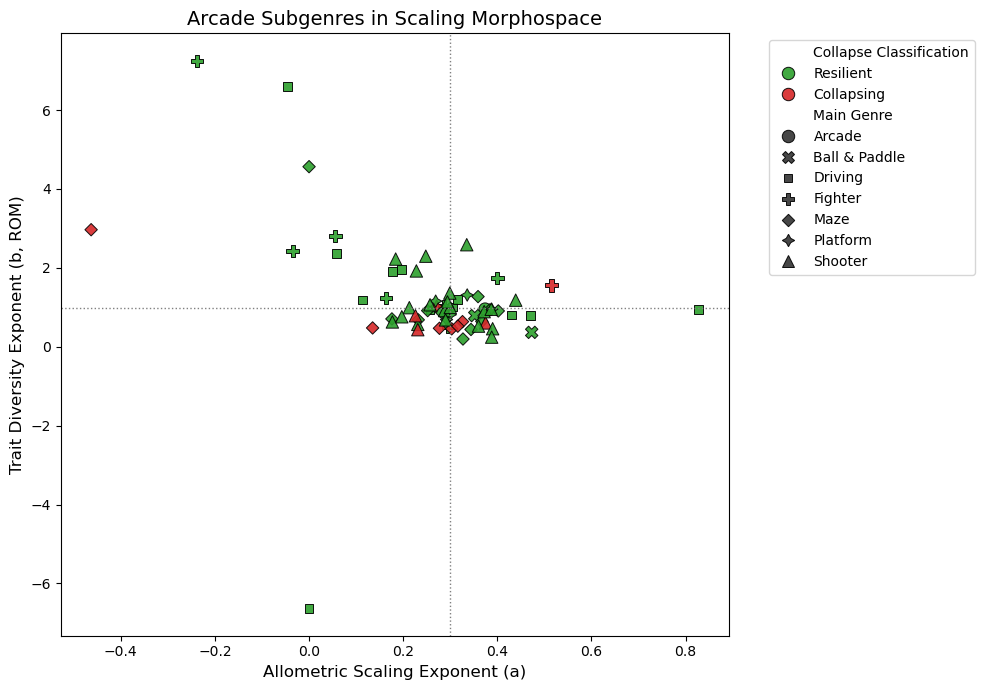

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out the global/all dataset
plot_df = df_results[df_results['Main Genre'] != 'ALL'].copy()

# Drop rows with missing values
plot_df = plot_df.dropna(subset=['Scaling Exponent a', 'Trait Diversity Exponent b (ROM)'])

# Color palette for collapse status
palette = {'Collapsing': 'tab:red', 'Resilient': 'tab:green'}

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=plot_df,
    x='Scaling Exponent a',
    y='Trait Diversity Exponent b (ROM)',
    hue='Collapse Classification',
    palette=palette,
    style='Main Genre',
    s=80,
    edgecolor='black',
    alpha=0.9
)

# plt.axhline(0.5, linestyle='dotted', color='gray', lw=1)
# plt.axvline(1.5, linestyle='dotted', color='gray', lw=1)

# ALL
#scaling exponent b
plt.axhline(0.972, linestyle='dotted', color='gray', lw=1)
# scaling exponent a
plt.axvline(0.3, linestyle='dotted', color='gray', lw=1)


plt.xlabel("Allometric Scaling Exponent (a)", fontsize=12)
plt.ylabel("Trait Diversity Exponent (b, ROM)", fontsize=12)
plt.title("Arcade Subgenres in Scaling Morphospace", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
plt.tight_layout()
plt.show()

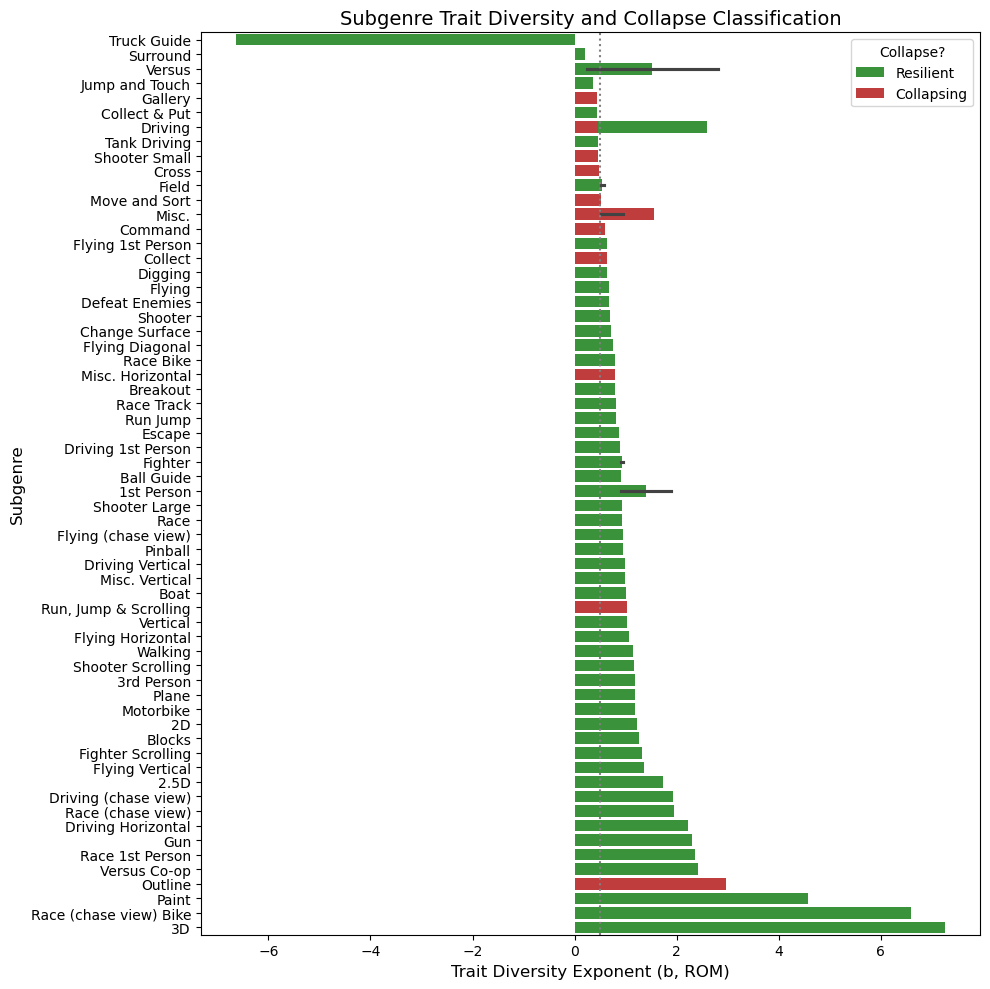

In [11]:
# Sort by b exponent
plot_df_sorted = plot_df.sort_values(by='Trait Diversity Exponent b (ROM)')

# Barplot
plt.figure(figsize=(10, 10))
sns.barplot(
    data=plot_df_sorted,
    x='Trait Diversity Exponent b (ROM)',
    y='Subgenre',
    hue='Collapse Classification',
    dodge=False,
    palette=palette
)

plt.axvline(0.5, linestyle='dotted', color='gray')
plt.xlabel("Trait Diversity Exponent (b, ROM)", fontsize=12)
plt.ylabel("Subgenre", fontsize=12)
plt.title("Subgenre Trait Diversity and Collapse Classification", fontsize=14)
plt.legend(title="Collapse?", loc='upper right')
plt.tight_layout()
plt.savefig("supplementary_fig_bbarplot.svg", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Genres to highlight, matching those in Figure 7
highlight_ids = {
    'Fighter/ALL': df_prod[df_prod['main_category'] == 'Fighter']['category_id'].unique(),
    'Platform/ALL': df_prod[df_prod['main_category'] == 'Platform']['category_id'].unique(),
    'Driving/ALL': df_prod[df_prod['main_category'] == 'Driving']['category_id'].unique(),
    'Shooter/Aerial': {0, 14, 21, 26, 47, 52}  # from your earlier figure
}

highlight_data = []

for label, ids in highlight_ids.items():
    sub_df = df_prod[df_prod['category_id'].isin(ids)]
    
    # Scaling a
    x = sub_df['log_rom_size']
    y = sub_df['log_clock_speed']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Trait diversity b (ROM)
    try:
        idx, V = get_trait_diversity(sub_df, trait_col='log_rom_size')
        params, cov = curve_fit(heap_law, idx, V, maxfev=10000)
        b, b_se = params[1], np.sqrt(np.diag(cov))[1]
    except Exception:
        b, b_se = np.nan, np.nan

    highlight_data.append({
        'Genre': label,
        'a': slope,
        'b': b,
        'a_se': std_err,
        'b_se': b_se
    })

highlight_df = pd.DataFrame(highlight_data)

Subcategories in dataset: {'Versus', '3D', 'Vertical', 'Misc.', '2D', '2.5D', 'Versus Co-op', 'Driving Vertical', 'Field', 'Medieval Tournament'}
Subcategories in dataset: {'Maze', 'Shooter Scrolling', 'Shooter', 'Fighter', 'Run Jump', 'Fighter Scrolling', 'Run, Jump & Scrolling'}
Subcategories in dataset: {'Landing', 'Boat', 'Race (chase view)', 'Race', 'Race Track', 'Motorbike (Motocross)', 'Guide and Shoot', 'Guide and Collect', 'Misc.', 'Race (chase view) Bike', 'Catch', 'Race 1st Person', 'Demolition Derby', '1st Person', 'Motorbike', 'FireTruck Guide', 'Ambulance Guide', 'Truck Guide', 'Plane', 'Race Bike'}
Subcategories in dataset: {'Flying (chase view)', 'Flying Vertical', 'Flying Horizontal', 'Flying 1st Person', 'Flying Diagonal', 'Flying'}


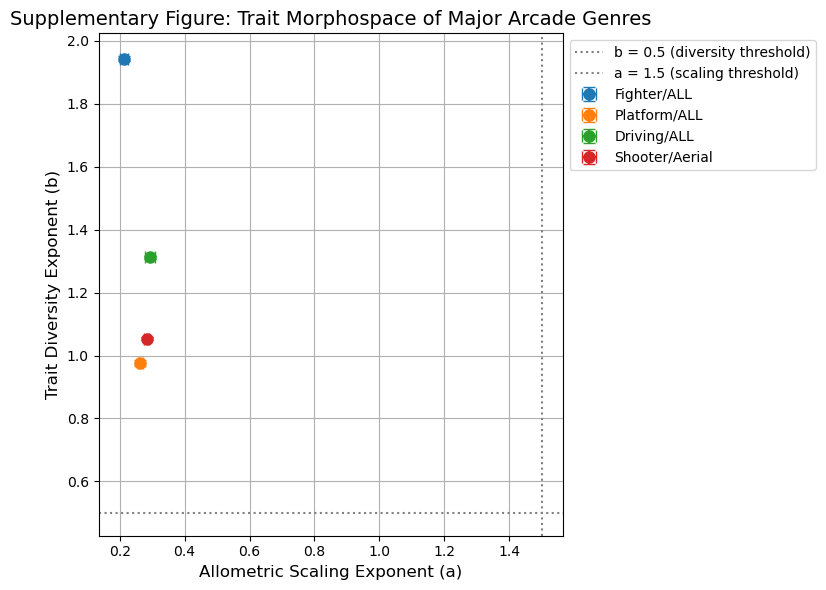

In [8]:
plt.figure(figsize=(8, 6))

# Scatter with error bars
for i, row in highlight_df.iterrows():
    plt.errorbar(row['a'], row['b'], 
                 xerr=row['a_se'], yerr=row['b_se'], 
                 fmt='o', markersize=8, capsize=4, 
                 label=row['Genre'])

# Thresholds from the main text
plt.axhline(0.5, ls='dotted', color='gray', label="b = 0.5 (diversity threshold)")
plt.axvline(1.5, ls='dotted', color='gray', label="a = 1.5 (scaling threshold)")

plt.xlabel("Allometric Scaling Exponent (a)", fontsize=12)
plt.ylabel("Trait Diversity Exponent (b)", fontsize=12)
plt.title("Supplementary Figure: Trait Morphospace of Major Arcade Genres", fontsize=14)
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.savefig("supplementary_fig_morphospace.svg", dpi=300, bbox_inches='tight')
plt.show()

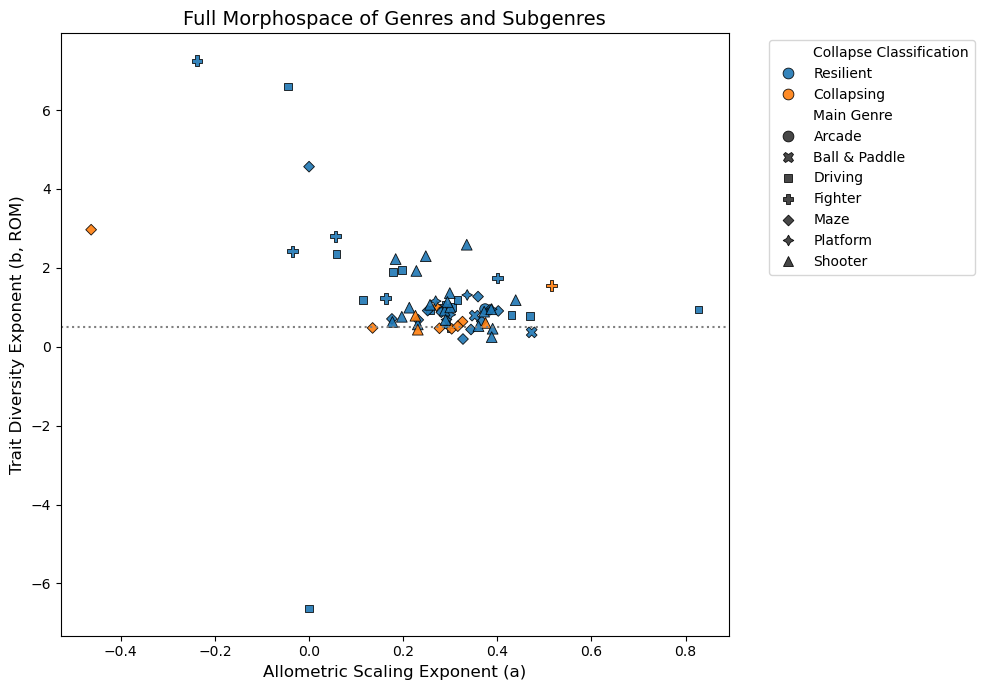

In [ ]:
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=df_results[df_results['Main Genre'] != 'ALL'],
    x='Scaling Exponent a',
    y='Trait Diversity Exponent b (ROM)',
    hue='Collapse Classification',
    style='Main Genre',
    s=60,
    alpha=0.9,
    edgecolor='black'
)

plt.axhline(0.5, linestyle='dotted', color='gray')
plt.xlabel("Allometric Scaling Exponent (a)", fontsize=12)
plt.ylabel("Trait Diversity Exponent (b, ROM)", fontsize=12)
plt.title("Full Morphospace of Genres and Subgenres", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("supplementary_fig_morphospace_all.svg", dpi=300, bbox_inches='tight')
plt.show()